# Crop Type Classification - Data Cleaning and visualization

This notebook illustrates the process of cleaning, preprocessing, and visualizing Normalized Difference Vegetation Index (NDVI) signature data. The resulting NDVI timeseries serves as input for training a crop type classification model in subsequent notebooks within this repository.

Outliers rejected by this workflow can be termed as non crop data. 

### Conda environment setup
Before running this notebook, let's build a conda environment. If you do not have conda installed, please follow the instructions from [Conda User Guide](https://docs.conda.io/projects/conda/en/latest/user-guide/index.html). 

```
$ conda create --name 'env_name' --file requirements.txt
$ conda activate 'env_name'
```

### Key Libraries:

- [Geopandas](https://geopandas.org/en/stable/docs.html), [Pandas]((https://xgboost.readthedocs.io/en/stable/)): Data handling and manipulation.
- [Matplotlib](https://matplotlib.org/stable/index.html): Utilized for data visualization.

### Meta Data information
- Crop types: Wheat, Mustard & Potato
- Time period recorded: fy 2022-23 (oct-22 to apr-23)
- Location: Madhya Pradesh, Uttar Pradesh
- Source: [Bhuvan Fasal(via MNCFC)](https://ncfc.gov.in/downloads/apps_update/FASAL_GT_CCE%20_Userguidelines.pdf) for Ground Truth and [Sentinel 2(via Google earth Engine)](https://developers.google.com/earth-engine/datasets/catalog/sentinel-2) for NDVI.

This workflow is performed on crop field data belonging to wheat, mustard and potato crops only (Bhuvan Fasal). However the same process can be extended to other crops grown in the Rabi season.

--------

# Imports

In [2]:
import os
try:
    if kernel_is_loaded:
        pass
except:
    os.chdir('/'.join(os.getcwd().split('/')[:-1]))
    kernel_is_loaded = True

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn.preprocessing import StandardScaler
import random
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 20

# Seeding
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

In [3]:
data = pd.read_csv('data_files/preprocessed_data.csv')
data.head(3)

,oct_1f,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f,apr_2f,crop_name,sowing_period,harvest_period
0,161.0,133.0,141.0,165.0,179.0,186.0,186.0,183.0,183.0,154.0,127.0,124.0,119.0,117.0,Mustard,oct_2f,feb_2f
1,166.0,129.0,143.0,168.0,180.0,187.0,187.0,186.0,187.0,150.0,121.0,119.0,117.0,117.0,Mustard,oct_2f,feb_2f
2,160.0,154.0,134.0,132.0,157.0,181.0,187.0,189.0,185.0,187.0,165.0,133.0,124.0,122.0,Wheat,nov_2f,mar_1f


# Train, Test and Validation split

In [4]:
# Samples with less than 3 occurrences cannot be divided into three parts (Train, Validation, Test). 
# These are excluded before splitting and then reintroduced to the training set to enhance generalization.

data['crop_sp_hp'] = data['crop_name']+'_'+data['sowing_period']+'_'+data['harvest_period']

comb_under_three = data.crop_sp_hp.value_counts()[data.crop_sp_hp.value_counts() < 3].index

samples_under_three = data[data['crop_sp_hp'].isin(comb_under_three)]

data.drop(samples_under_three.index, inplace=True)

samples_under_three.shape[0]

23

In [5]:
# Train-Validation-Test split: 60-20-20 by keeping the data distribution constant across all 3 data sets.
# Stratification is perfomed based on crop_name, sowing_period and harvest_period. 

train_test, val = train_test_split(data, test_size=0.2, 
                                   stratify=data[['crop_name', 'sowing_period', 'harvest_period']], random_state=0)

train, test = train_test_split(train_test, test_size=0.25, 
                                   stratify=train_test[['crop_name', 'sowing_period', 'harvest_period']], random_state=0)

display(train.shape, val.shape, test.shape, 
        train.crop_name.value_counts(normalize=True), val.crop_name.value_counts(normalize=True), test.crop_name.value_counts(normalize=True),
        train.crop_name.value_counts(normalize=False), val.crop_name.value_counts(normalize=False), test.crop_name.value_counts(normalize=False))

(7113, 18)

(2371, 18)

(2371, 18)

Wheat      0.551947
Potato     0.272037
Mustard    0.176016
Name: crop_name, dtype: float64

Wheat      0.551666
Potato     0.272037
Mustard    0.176297
Name: crop_name, dtype: float64

Wheat      0.552509
Potato     0.271615
Mustard    0.175875
Name: crop_name, dtype: float64

Wheat      3926
Potato     1935
Mustard    1252
Name: crop_name, dtype: int64

Wheat      1308
Potato      645
Mustard     418
Name: crop_name, dtype: int64

Wheat      1310
Potato      644
Mustard     417
Name: crop_name, dtype: int64

In [6]:
# Adding samples with less than 3 occurrences back to the training set to aid generalization. 

train = pd.concat([train, samples_under_three], axis=0)

# Label Encoding

In [7]:
# Label Encoding crop classes. 

crop_label = {'Mustard':0, 'Wheat':1, 'Potato':2}

for df in train, val, test:
    df['crop_name'] = df['crop_name'].apply(lambda crop:crop_label[crop])
    df.drop(['sowing_period', 'harvest_period', 'crop_sp_hp'], axis=1, inplace=True)

# Scaling

In [8]:
# Fitting the train set to the standard scaler and transforming the test and validation sets

scaler = StandardScaler()

train.loc[:,'oct_1f':'apr_2f'] = scaler.fit_transform(train.drop('crop_name', axis=1))
val.loc[:,'oct_1f':'apr_2f'] = scaler.transform(val.drop('crop_name', axis=1))
test.loc[:,'oct_1f':'apr_2f'] = scaler.transform(test.drop('crop_name', axis=1))

# File Export

In [33]:
train.to_csv('data_files/train.csv', index=False)
val.to_csv('data_files/val.csv', index=False)
test.to_csv('data_files/test.csv', index=False)

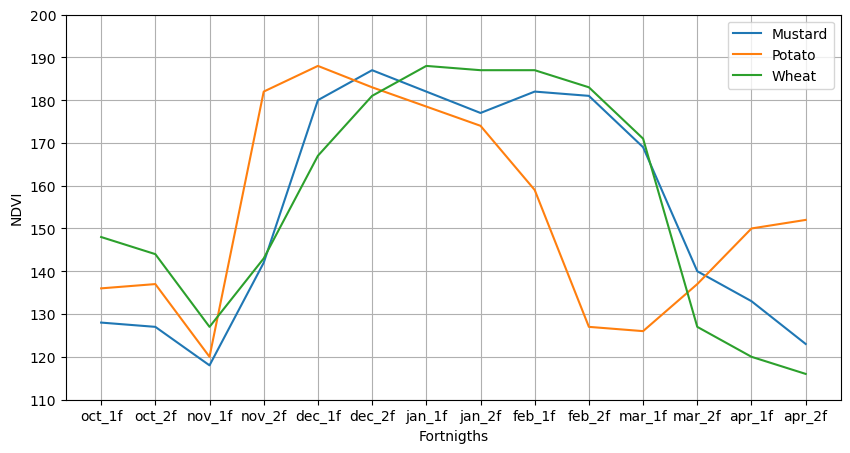

In [61]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(10,40))
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams['axes.grid'] = True

axes = data[(data['crop_name'] == 'Mustard') & (data['sowing_period'] == 'nov_1f')].loc[:,'oct_1f': 'apr_2f'].sample(1, random_state=1).T.plot()
data[(data['crop_name'] == 'Potato') & (data['sowing_period'] == 'nov_1f')].loc[:,'oct_1f': 'apr_2f'].sample(1, random_state=0).T.plot(ax=axes)
data[(data['crop_name'] == 'Wheat') & (data['sowing_period'] == 'nov_1f')].loc[:,'oct_1f': 'apr_2f'].sample(1, random_state=0).T.plot(ax=axes)
# axes.set_xticks(data.loc[:,'oct_1f': 'apr_2f'].columns)

plt.setp(axes,  xticks = np.arange(0,14,1), xticklabels = data.loc[:,'oct_1f':'apr_2f'].columns,
         yticks=np.arange(60,220,10), ylim=[110,200], xlabel = 'Fortnigths', ylabel = 'NDVI')
axes.legend(['Mustard', 'Potato', 'Wheat'])
plt.show()